## Modelisation de la frequence sinistre

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA


In [2]:
Actuar1=pd.read_csv("actuarNV1.csv",sep=";")

In [3]:
Actuar1.head()

,nocontrat,exposition,zone,puissance,agevehicule,ageconducteur,bonus,marque,carburant,densite,region,nbre,no,garantie,cout
0,217,0.74,A,5,4,31,64,3,D,21,8,1,17001,1RC,0.00
1,709,0.18,B,7,8,22,100,2,E,26,0,1,17419,1RC,0.00
2,714,0.48,C,9,0,32,61,12,E,41,13,1,15851,4BG,687.82
3,852,0.27,F,7,5,39,100,12,E,11,0,1,21407,2DO,96.64
4,1083,0.51,E,4,0,49,50,12,E,31,13,1,15589,2DO,70.88


In [4]:
#Suppression et Renomination des colonnes
Actuar1=Actuar1.drop(columns=['nocontrat'])
Actuar1=Actuar1.drop(columns=['no'])
Actuar1=Actuar1.drop(columns=['exposition'])
Actuar1=Actuar1.drop(columns=['region'])
Actuar1=Actuar1.drop(columns=['marque'])

Actuar1.rename(columns={
    'exposition':'exposition',
    'zone':'zone',
    'puissance':'puissance',
    'agevehicule':'age_vehicule',
    'ageconducteur':'age_conducteur',
    'bonus':'bonus',
    'marque':'marque',
    'carburant':'energie',
    'region':'region',
    'nbre':'frequence_sinistre',
    'garantie':'garantie',
    'cout':'cout'
},inplace=True)

In [5]:
#Affichage des colonnes renommees
Actuar1.columns

Index(['zone', 'puissance', 'age_vehicule', 'age_conducteur', 'bonus',
       'energie', 'densite', 'frequence_sinistre', 'garantie', 'cout'],
      dtype='object')

In [6]:
Actuar1.head()

,zone,puissance,age_vehicule,age_conducteur,bonus,energie,densite,frequence_sinistre,garantie,cout
0,A,5,4,31,64,D,21,1,1RC,0.00
1,B,7,8,22,100,E,26,1,1RC,0.00
2,C,9,0,32,61,E,41,1,4BG,687.82
3,F,7,5,39,100,E,11,1,2DO,96.64
4,E,4,0,49,50,E,31,1,2DO,70.88


In [7]:
# Vérifier les doublons dans l'ensemble du DataFrame
Actuar1.duplicated().sum()

9

In [8]:
Actuar1=Actuar1.drop_duplicates()

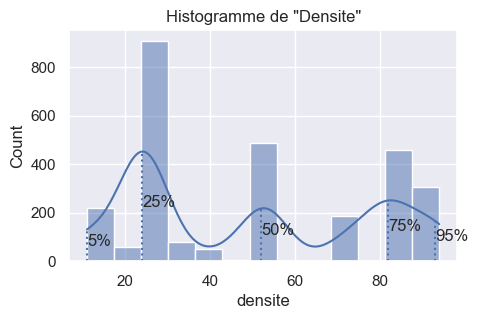

In [9]:
#Densite
sns.set(rc = {'figure.figsize':(5,3)})
ax = sns.histplot(x = Actuar1['densite'], kde=True)
quant_5 = Actuar1['densite'].quantile(0.05)
quant_25 = Actuar1['densite'].quantile(0.25)
quant_50 = Actuar1['densite'].quantile(0.5)
quant_75 = Actuar1['densite'].quantile(0.75)
quant_95 = Actuar1['densite'].quantile(0.95)
quant_dict = {'5%': quant_5, '25%': quant_25, '50%': quant_50, '75%': quant_75,'95%': quant_95}
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
for key, value in quant_dict.items():
    height = np.interp(value, xs, ys)
    ax.vlines(value, 0, height, ls=':')
    ax.text(value , height * 0.5, key, rotation=0)
plt.title('Histogramme de "Densite"')
plt.show()


In [10]:
variables_quantitatives=Actuar1.select_dtypes(include=['float64','int64']).columns

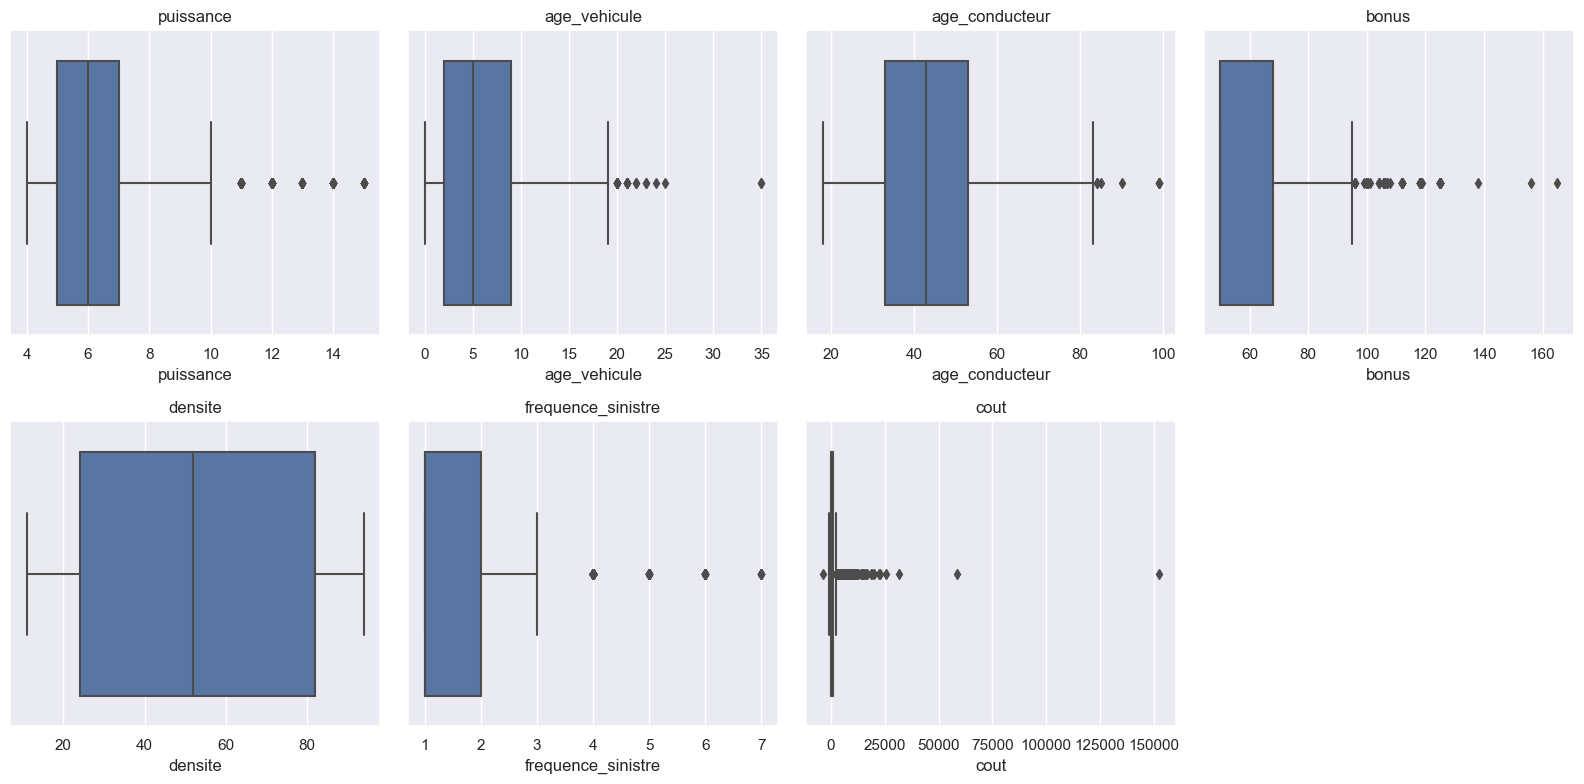

In [11]:
# Créer une disposition en grille pour les sous-graphiques avec 2 lignes et 4 colonnes
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Parcourir chaque colonne et créer un diagramme en boîte pour les valeurs aberrantes
for i, colonne in enumerate(variables_quantitatives):
    # Calcul des positions dans la grille
    ligne = i // 4
    col = i % 4
    # Créer un diagramme en boîte pour chaque variable
    sns.boxplot(x=Actuar1[colonne], ax=axes[ligne, col])
    axes[ligne, col].set_title(colonne)  # Ajouter le titre de la variable

# Supprimer le dernier sous-graphe vide
fig.delaxes(axes[1, 3])

plt.tight_layout()
plt.show()


In [12]:
lower_limit=0.05
upper_limit=0.95

In [13]:
def winsorize_dataframe(Actuar1, lower_limit, upper_limit):
        """Winsorise les colonnes numériques d'un dataframe."""

   # Winsorise chaque colonne numérique

for col in variables_quantitatives:
        
        Actuar1[col] = winsorize(Actuar1[col], limits=[lower_limit, 1 - upper_limit])


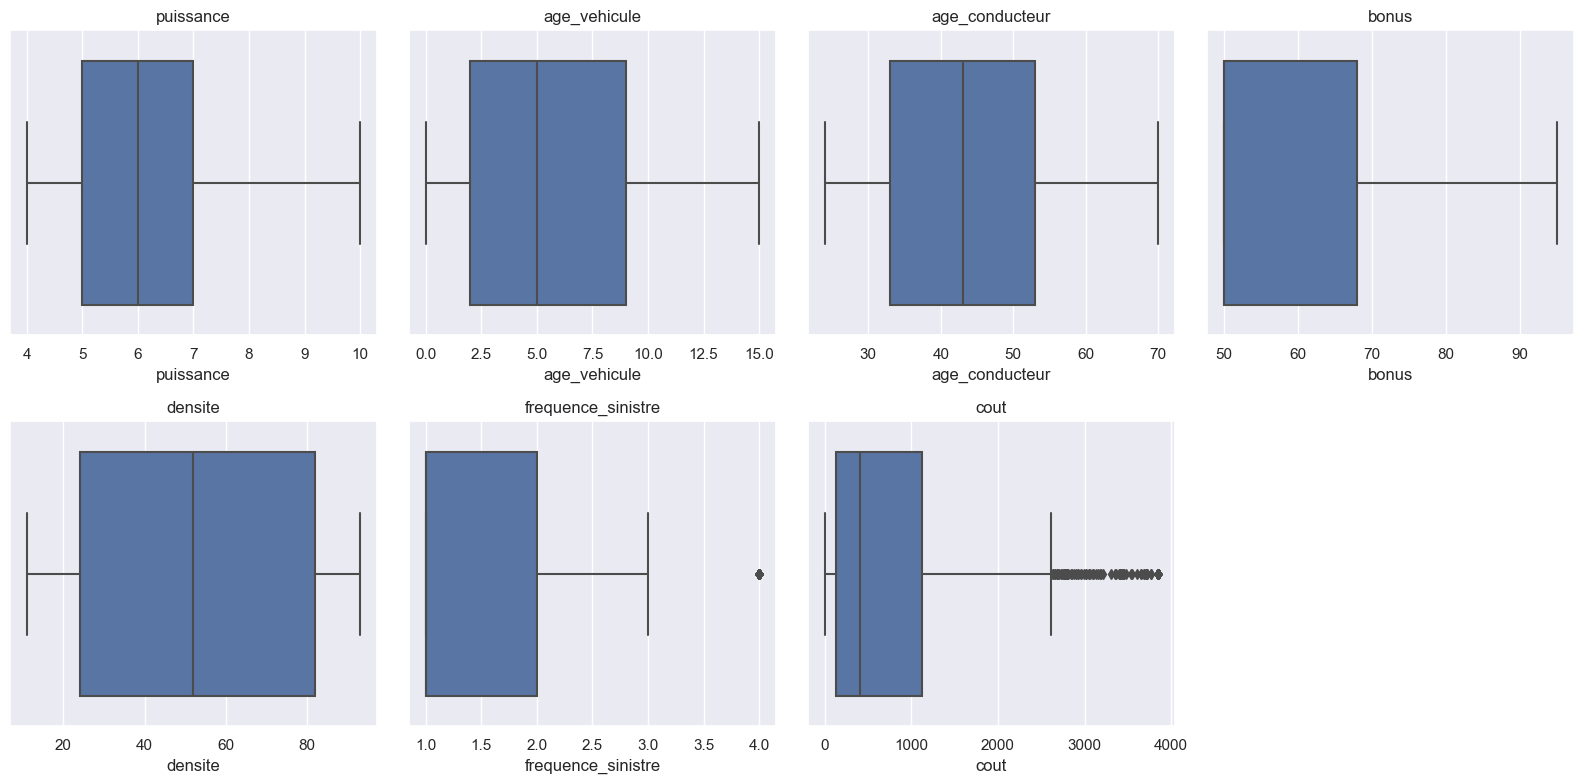

In [14]:
# Créer une disposition en grille pour les sous-graphiques avec 2 lignes et 4 colonnes
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Parcourir chaque colonne et créer un diagramme en boîte pour les valeurs aberrantes
for i, colonne in enumerate(variables_quantitatives):
    # Calcul des positions dans la grille
    ligne = i // 4
    col = i % 4
    # Créer un diagramme en boîte pour chaque variable
    sns.boxplot(x=Actuar1[colonne], ax=axes[ligne, col])
    axes[ligne, col].set_title(colonne)  # Ajouter le titre de la variable

# Supprimer le dernier sous-graphe vide
fig.delaxes(axes[1, 3])

plt.tight_layout()
plt.show()


In [15]:
variables_qualitatives=Actuar1.select_dtypes(include=['object'])

In [16]:
#Définition d'une fonction slrViz_corr
def slrViz_corr(var):
    sns.regplot(x = var, y = Actuar1['frequence_sinistre'])
    plt.ylim(0,)
    Pearson_coef, P_value = stats.pearsonr(var, Actuar1['frequence_sinistre'])

    return print('Le coefficient de corrélation de Pearson est', Pearson_coef, 'avec une P-valeur de', P_value)

Le coefficient de corrélation de Pearson est 0.02435238638922369 avec une P-valeur de 0.20123114186799196


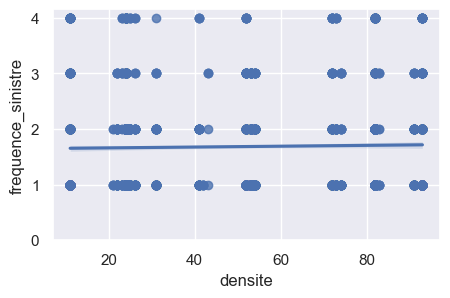

In [17]:
#Régression linéaire simple de 'frequence_sinistre' en fonction de 'densite'
slrViz_corr(Actuar1['densite'])


Le coefficient de corrélation de Pearson est 0.011755870684915985 avec une P-valeur de 0.5373029541673853


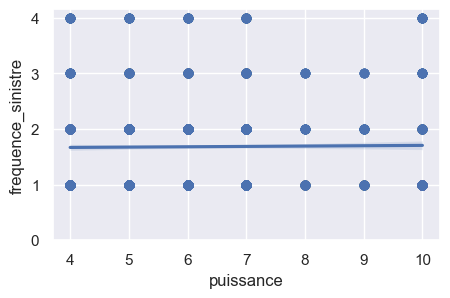

In [18]:
#Régression linéaire simple de 'frequence_sinistre' en fonction de 'puissance'
slrViz_corr(Actuar1['puissance'])

Le coefficient de corrélation de Pearson est -0.12216810612989058 avec une P-valeur de 1.236840669704428e-10


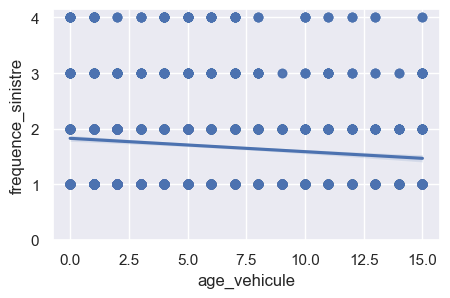

In [19]:
#Régression linéaire simple de 'frequence_sinistre' en fonction de 'age_vehicule'
slrViz_corr(Actuar1['age_vehicule'])

Le coefficient de corrélation de Pearson est -0.02541819271154754 avec une P-valeur de 0.18220229499295776


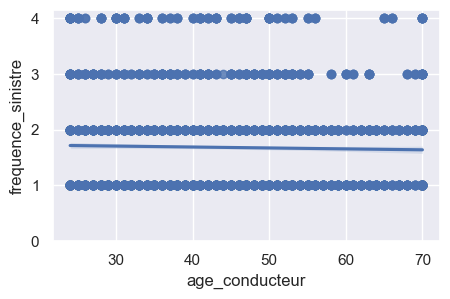

In [20]:
#Régression linéaire simple de 'frequence_sinistre' en fonction de 'age_vehicule'
slrViz_corr(Actuar1['age_conducteur'])

Le coefficient de corrélation de Pearson est 0.05942471105462107 avec une P-valeur de 0.001802387528828563


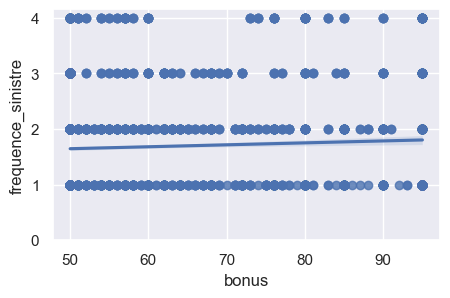

In [21]:
#Régression linéaire simple de 'frequence_sinistre' en fonction de 'bonus'
slrViz_corr(Actuar1['bonus'])

Le coefficient de corrélation de Pearson est 0.061353974720918227 avec une P-valeur de 0.0012707163399411265


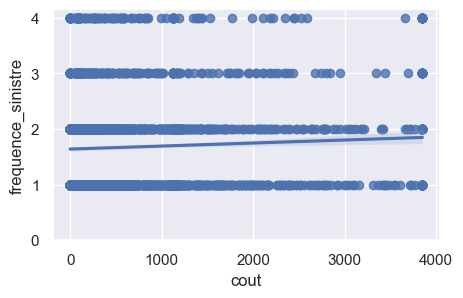

In [22]:
#Régression linéaire simple de 'frequence_sinistre' en fonction de 'cout'
slrViz_corr(Actuar1['cout'])

<AxesSubplot: xlabel='zone', ylabel='frequence_sinistre'>

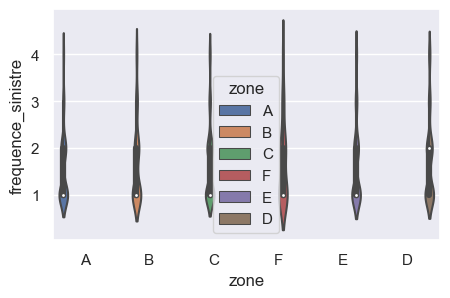

In [23]:
sns.violinplot(x = 'zone', y = 'frequence_sinistre', data = Actuar1,hue='zone')


<AxesSubplot: xlabel='energie', ylabel='frequence_sinistre'>

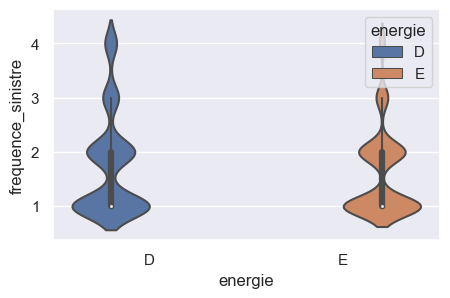

In [24]:
sns.violinplot(x = 'energie', y = 'frequence_sinistre', data = Actuar1,hue='energie')


<AxesSubplot: xlabel='garantie', ylabel='frequence_sinistre'>

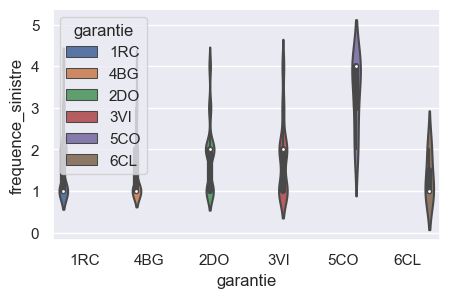

In [25]:
sns.violinplot(x = 'garantie', y = 'frequence_sinistre', data = Actuar1,hue='garantie')


In [26]:
from scipy.stats import chi2_contingency

# Initialiser les listes pour stocker les résultats
var_names = []
chi2_stats = []
p_values = []
cramer_vs = []

# Parcourir toutes les variables catégorielles
for var in variables_qualitatives:
    # Calculer le tableau de contingence
    contingency_table = pd.crosstab(Actuar1['frequence_sinistre'], Actuar1[var])
    # Calculer la statistique de test du Chi-deux et la p-valeur
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    # Calculer le coefficient V de Cramer
    n = contingency_table.sum().sum()
    phi2 = chi2/n
    r,k = contingency_table.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rc = r-((r-1)**2)/(n-1)
    kc = k-((k-1)**2)/(n-1)
    cramer_v = np.sqrt(phi2corr/min(rc-1,kc-1))
    # Ajouter les résultats aux listes correspondantes
    var_names.append(var)
    chi2_stats.append(chi2)
    p_values.append(p)
    cramer_vs.append(cramer_v)

# Créer un DataFrame avec les résultats
results_df = pd.DataFrame({
    'Variable': var_names,
    'Chi2': chi2_stats,
    'P-valeur': p_values,
    'V de Cramer': cramer_vs
})

# Trier le DataFrame par ordre croissant de V de Cramer
results_df.sort_values(by='V de Cramer', inplace=True,ascending=False)

# Afficher le tableau des résultats
print(results_df)

   Variable        Chi2      P-valeur  V de Cramer
2  garantie  290.064935  6.461891e-53     0.182494
1   energie   27.120165  5.555546e-06     0.093566
0      zone   14.911064  4.578422e-01     0.000000


## Interprétation des résultats :
**Variable garantie** :

*Chi2* : 290.06
*P-valeur* : 6.46e-53
*V de Cramer* : 0.1825
La statistique Chi-deux est très élevée (290.06) et la p-valeur est extrêmement faible (6.46e-53), bien en dessous du seuil typique de 0.05. Cela indique une association statistiquement significative entre garantie et frequence_sinistre. Le coefficient V de Cramer (0.1825) suggère une association modérée entre ces deux variables.

**Variable energie** :

*Chi2* : 27.12
*P-valeur* : 5.56e-06
*V de Cramer* : 0.0936
La statistique Chi-deux est de 27.12 et la p-valeur est très faible (5.56e-06), également bien en dessous de 0.05. Cela indique une association statistiquement significative entre energie et frequence_sinistre. Le coefficient V de Cramer (0.0936) suggère une association faible à modérée entre ces deux variables.

**Variable zone** :

*Chi2* : 14.91
*P-valeur* : 0.4578
*V de Cramer* : 0.0000
La statistique Chi-deux est de 14.91, mais la p-valeur est de 0.4578, bien au-dessus du seuil de 0.05. Cela indique qu'il n'y a pas d'association statistiquement significative entre zone et frequence_sinistre. Le coefficient V de Cramer est de 0.0000, confirmant qu'il n'y a aucune association entre zone et frequence_sinistre.

Conclusion :
garantie et frequence_sinistre : Il existe une association statistiquement significative avec une force d'association modérée.
energie et frequence_sinistre : Il existe une association statistiquement significative avec une force d'association faible à modérée.
zone et frequence_sinistre : Il n'y a pas d'association statistiquement significative.
Ces résultats indiquent que les variables garantie et energie ont un certain degré d'influence sur frequence_sinistre, tandis que zone n'a pas d'influence significative sur cette variable quantitative.

In [27]:
from sklearn.preprocessing import LabelEncoder


In [28]:
encoded=LabelEncoder().fit_transform(Actuar1['zone'])
encoded=LabelEncoder().fit_transform(Actuar1['energie'])
encoded=LabelEncoder().fit_transform(Actuar1['garantie'])

Actuar1['zone']=encoded
Actuar1['energie']=encoded
Actuar1['garantie']=encoded

Actuar1.head()

,zone,puissance,age_vehicule,age_conducteur,bonus,energie,densite,frequence_sinistre,garantie,cout
0,0,5,4,31,64,0,21,1,0,0.00
1,0,7,8,24,95,0,26,1,0,0.00
2,3,9,0,32,61,3,41,1,3,687.82
3,1,7,5,39,95,1,11,1,1,96.64
4,1,4,0,49,50,1,31,1,1,70.88


In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [30]:
import statsmodels.api as sm


In [31]:
#Separation des variables independantes et la variable dependante
X_1=Actuar1.drop('frequence_sinistre',axis=1)
Y_1=Actuar1['frequence_sinistre']

In [32]:
X_1

,zone,puissance,age_vehicule,age_conducteur,bonus,energie,densite,garantie,cout
0,0,5,4,31,64,0,21,0,0.00
1,0,7,8,24,95,0,26,0,0.00
2,3,9,0,32,61,3,41,3,687.82
3,1,7,5,39,95,1,11,1,96.64
4,1,4,0,49,50,1,31,1,70.88
...,...,...,...,...,...,...,...,...,...
2760,3,7,8,31,54,3,52,3,156.23
2761,0,5,4,32,57,0,24,0,74.15
2762,3,5,15,44,50,3,24,3,325.57
2763,3,5,7,48,50,3,24,3,387.04


In [33]:
Y_1

0       1
1       1
2       1
3       1
4       1
       ..
2760    1
2761    1
2762    1
2763    1
2764    1
Name: frequence_sinistre, Length: 2756, dtype: int64

In [34]:
#Ajouter une constante a notre modele
X_1=sm.add_constant(X_1)

In [35]:
#Ajuster le modele de regression de poisson
poisson_model=sm.GLM(Y_1,X_1,family=sm.families.Poisson()).fit()

#Resume du modele
print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:     frequence_sinistre   No. Observations:                 2756
Model:                            GLM   Df Residuals:                     2748
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3779.3
Date:                Wed, 03 Jul 2024   Deviance:                       1045.3
Time:                        14:30:49   Pearson chi2:                 1.16e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01866
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5519      0.129      4.

Voici une interprétation détaillée des résultats du modèle de régression linéaire généralisée (GLM) utilisant la famille Poisson et la fonction de lien logarithmique pour prédire la fréquence des sinistres.

### Résumé des résultats
- **Nombre d'observations (No. Observations)**: 2756
- **Degrés de liberté résiduels (Df Residuals)**: 2748
- **Degrés de liberté du modèle (Df Model)**: 7
- **Méthode (Method)**: IRLS (Iteratively Reweighted Least Squares)
- **Log-Vraisemblance (Log-Likelihood)**: -3779.3
- **Déviance (Deviance)**: 1045.3
- **Chi-carré de Pearson (Pearson chi2)**: 1.16e+03
- **Pseudo R-carré (CS)**: 0.01866
- **Nombre d'itérations (No. Iterations)**: 4

### Coefficients et leur interprétation

- **Constante (const)**: 
  - Coefficient: 0.5519
  - P-valeur: 0.000 (significatif)
  - Interprétation: La valeur de la constante est statistiquement significative, indiquant une influence de la constante sur la fréquence des sinistres.

- **Zone**:
  - Coefficient: -0.0205
  - P-valeur: 0.000 (significatif)
  - Interprétation: Pour chaque unité supplémentaire de la variable "zone", la fréquence des sinistres diminue de 0.0205. Cela signifie qu'une zone différente peut influencer négativement la fréquence des sinistres.

- **Puissance**:
  - Coefficient: 0.0068
  - P-valeur: 0.447 (non significatif)
  - Interprétation: La puissance du véhicule n'a pas d'effet significatif sur la fréquence des sinistres.

- **Âge du véhicule (age_vehicule)**:
  - Coefficient: -0.0146
  - P-valeur: 0.000 (significatif)
  - Interprétation: Pour chaque année supplémentaire de l'âge du véhicule, la fréquence des sinistres diminue de 0.0146.

- **Âge du conducteur (age_conducteur)**:
  - Coefficient: -0.0006
  - P-valeur: 0.626 (non significatif)
  - Interprétation: L'âge du conducteur n'a pas d'effet significatif sur la fréquence des sinistres.

- **Bonus**:
  - Coefficient: 0.0014
  - P-valeur: 0.204 (non significatif)
  - Interprétation: Le bonus n'a pas d'effet significatif sur la fréquence des sinistres.

- **Énergie**:
  - Coefficient: -0.0205
  - P-valeur: 0.000 (significatif)
  - Interprétation: Le type de carburant utilisé a un effet significatif sur la fréquence des sinistres, avec une diminution de 0.0205 pour chaque unité de la variable "énergie".

- **Densité**:
  - Coefficient: 0.0002
  - P-valeur: 0.666 (non significatif)
  - Interprétation: La densité n'a pas d'effet significatif sur la fréquence des sinistres.

- **Garantie**:
  - Coefficient: -0.0205
  - P-valeur: 0.000 (significatif)
  - Interprétation: La garantie a un effet significatif sur la fréquence des sinistres, avec une diminution de 0.0205 pour chaque unité de la variable "garantie".

- **Coût (cout)**:
  - Coefficient: 2.101e-05
  - P-valeur: 0.153 (non significatif)
  - Interprétation: Le coût n'a pas d'effet significatif sur la fréquence des sinistres.

### Conclusion

Les variables "zone", "âge du véhicule", "énergie" et "garantie" ont des effets significatifs sur la fréquence des sinistres, tandis que les autres variables comme "puissance", "âge du conducteur", "bonus", "densité" et "coût" n'ont pas d'effet significatif. 

Le Pseudo R-carré (CS) de 0.01866 indique que le modèle explique environ 1.87% de la variabilité de la fréquence des sinistres, ce qui est relativement faible. Cela suggère que d'autres facteurs non inclus dans le modèle pourraient influencer la fréquence des sinistres.

In [36]:
# Calculer le ratio de la déviance sur les degrés de liberté
deviance = poisson_model.deviance
degrees_of_freedom = poisson_model.df_resid
ratio = deviance / degrees_of_freedom
print(f'Ratio deviance/degrees of freedom: {ratio}')

# Si le ratio est nettement supérieur à 1, cela indique une surdispersion


Ratio deviance/degrees of freedom: 0.3803990005503866


Le ratio déviance/degrés de liberté est un indicateur utilisé pour évaluer l'ajustement d'un modèle statistique, en particulier dans les modèles de régression généralisée (GLM). Voici une interprétation du ratio que vous avez obtenu:

### Ratio déviance/degrés de liberté
- **Valeur**: 0.3804

### Interprétation
1. **Valeur du ratio**: Un ratio de 0.3804 est inférieur à 1, ce qui indique que la déviance (une mesure de l'ajustement du modèle) est faible par rapport au nombre de degrés de liberté. Cela peut suggérer que le modèle s'ajuste bien aux données.
  
2. **Comparaison avec 1**: En général, un ratio déviance/degrés de liberté proche de 1 indique un bon ajustement du modèle. Si le ratio est bien inférieur à 1, cela peut indiquer une sous-dispersion des données par rapport au modèle. En revanche, un ratio bien supérieur à 1 indiquerait une surdispersion.
   
3. **Sous-dispersion**: Dans ce cas, la sous-dispersion (ratio inférieur à 1) peut suggérer que les observations ont moins de variabilité que celle prévue par le modèle. Cela peut également signifier que le modèle pourrait être trop simple et ne capture pas toute la variabilité présente dans les données, ou que les résidus sont trop petits.

### Conclusion
Le ratio de déviance/degrés de liberté de 0.3804 suggère que le modèle de régression Poisson que vous avez ajusté est probablement bien ajusté aux données, avec une légère tendance vers la sous-dispersion. Cela signifie que le modèle prédit la fréquence des sinistres avec une variabilité légèrement moindre que celle observée dans les données. Cependant, il est toujours recommandé de vérifier d'autres diagnostics du modèle pour s'assurer de la robustesse de ces conclusions.

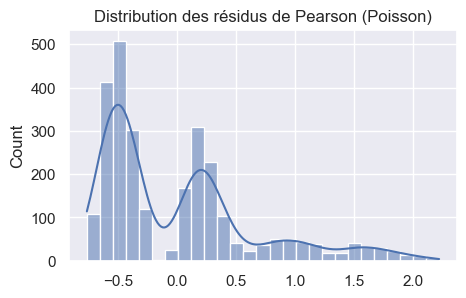

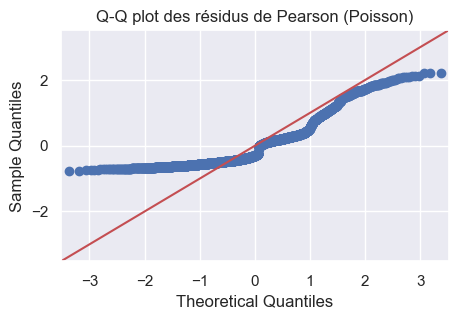

In [37]:
# Résidus de Pearson
residuals = poisson_model.resid_pearson

# Visualisation des résidus
sns.histplot(residuals, kde=True)
plt.title('Distribution des résidus de Pearson (Poisson)')
plt.show()

# Q-Q plot des résidus
sm.qqplot(residuals, line='45')
plt.title('Q-Q plot des résidus de Pearson (Poisson)')
plt.show()
